# LSTM Model for Urban Sound Classification

## Installing Required Libraries

In [1]:
!pip install librosa

In [2]:
!pip install tensorflow

In [3]:
!pip install matplotlib

In [4]:
!pip install pandas

In [5]:
!pip install tqdm

In [6]:
!pip install imbalanced-learn

In [7]:
!pip install keras-tuner

In [8]:
!pip install seaborn

## Importing Required Dependencies

In [31]:
# Standard Libraries
import os
from collections import Counter
import IPython.display as ipd

# Data Handling Libraries
import numpy as np
import pandas as pd
import joblib

# Audio Processing Libraries
import librosa
import librosa.display

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Deep Learning Libraries (Tensorflow/Keras)
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, LSTM, Bidirectional
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras_tuner import HyperModel
from keras.optimizers import Adam

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [32]:
metadata = pd.read_csv('../Data/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [11]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        return None
    return mfccs_scaled

In [19]:
audio_dataset_path = r'F:\\SE\\SLIIT\\Y04S01\\Deep Learning\\Assignments\\DL\\Data'

In [12]:
features = []
labels = []

In [ ]:
for index_num,row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=extract_features(file_name)
    features.append(data)
    labels.append(final_class_labels)

In [ ]:
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels, columns=['label'])

df_extracted_features = pd.concat([df_features, df_labels], axis=1)

df_extracted_features.to_csv('./audio_features.csv', index=False)

In [33]:
df_audio_features = pd.read_csv('../Results/audio_features.csv')
df_audio_features

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-275.91843,119.49279,-98.211780,-66.515130,-42.606050,0.505065,-28.330935,-5.746867,9.992785,4.795413,...,-3.562048,1.710329,1.032514,-4.748237,-4.013623,0.116840,6.310030,1.492272,1.462319,dog_bark
1,-500.90840,185.10641,-86.532820,49.858840,9.230822,22.548956,-3.567174,12.220052,7.720082,-6.460392,...,-1.856354,0.372866,-3.269187,-1.969773,-1.598099,0.562077,0.463689,-0.359663,0.909601,children_playing
2,-531.19530,186.93994,-70.349170,40.429245,9.121048,18.398588,6.283282,15.504061,9.613500,-7.113610,...,-0.291961,0.287639,-3.358315,1.434628,-0.975246,2.386079,-0.347919,-3.844178,-0.731597,children_playing
3,-476.78442,160.33328,-62.952843,50.751170,-0.174330,32.791600,-17.469800,24.755478,-3.847783,-1.761176,...,-3.374202,-1.012279,-1.025993,-3.666372,-0.071535,-5.693183,1.876606,-1.428173,3.510686,children_playing
4,-521.24470,185.39265,-81.950480,46.473550,11.872087,23.491444,4.261836,13.637699,6.093238,-2.813453,...,-0.331206,2.441440,0.449652,1.609697,-2.679410,-0.054824,-2.050368,-1.784189,2.869685,children_playing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-466.63190,193.29425,-63.960163,30.475616,-9.339019,23.975900,-14.627114,27.502554,3.764654,4.351698,...,-5.908267,-0.086640,8.064040,4.842944,-1.370681,-8.400169,1.039637,2.128600,4.718456,car_horn
8728,-396.77737,134.76804,-64.882770,42.310800,-1.868765,0.876937,-36.872650,42.781456,-9.984668,-5.920936,...,1.580030,-4.441753,3.187478,-3.398616,1.737199,3.312875,2.611360,0.158990,0.844662,car_horn
8729,-362.70322,165.08179,-60.780693,30.996470,-9.655406,23.180807,-18.668150,27.321250,-7.465636,7.173613,...,2.579410,-2.790286,2.743991,-4.914998,-4.034191,-5.768603,-1.840645,2.607495,3.903050,car_horn
8730,-404.62810,178.50473,-63.615627,25.944529,-10.428956,12.489921,-24.788843,35.468410,-3.097389,0.915603,...,-0.693243,-2.208296,4.955165,-0.435411,-1.857112,-7.561953,-0.168980,3.911847,4.805304,car_horn


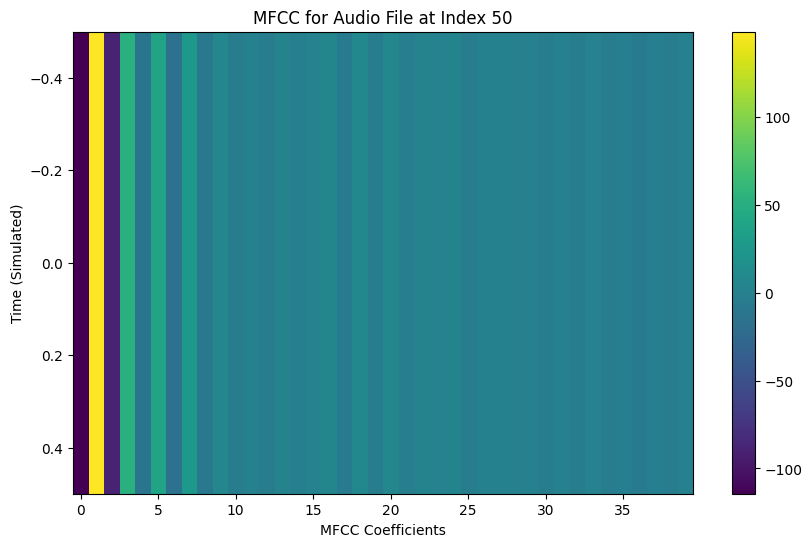

In [34]:
def plot_extracted_mfcc(df, file_index):
    
    mfcc_features = df.iloc[file_index, :-1].values

    mfcc_features = mfcc_features.astype(float)

    mfcc_matrix = mfcc_features.reshape(1, -1) 

    plt.figure(figsize=(10, 6))
    plt.imshow(mfcc_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'MFCC for Audio File at Index {file_index}')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Time (Simulated)')
    plt.show()

plot_extracted_mfcc(df_audio_features, file_index=50)

In [35]:
X = df_audio_features.drop(columns=['label']).values
y = df_audio_features['label'].values

In [36]:
y=np.array(pd.get_dummies(y,dtype=int))
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [37]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled_labels = np.argmax(y_resampled, axis=1)

counter = Counter(y_resampled_labels)

print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({3: 1000, 2: 1000, 1: 1000, 0: 1000, 9: 1000, 6: 1000, 8: 1000, 5: 1000, 7: 1000, 4: 1000})


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [39]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'lstm_standard_scaler.pkl')

['lstm_standard_scaler.pkl']

In [40]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# One-hot encode the labels
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

In [41]:
class LSTMHyperModel(HyperModel):

    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units

    def build(self, hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int('units_layer1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_layer1', values=['relu', 'tanh', 'sigmoid']),
            input_shape=self.input_shape,
            return_sequences=True
        ))
        model.add(Dropout(hp.Float('dropout_layer1', min_value=0, max_value=0.5, step=0.1)))

        # Second LSTM layer
        model.add(LSTM(
            units=hp.Int('units_layer2', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_layer2', values=['relu', 'tanh', 'sigmoid'])
        ))
        model.add(Dropout(hp.Float('dropout_layer2', min_value=0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.output_units, activation='softmax'))

        # Compile the model
        model.compile(optimizer=Adam(
                          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [43]:
possible_epochs = [50, 100]

In [44]:
input_shape = (40, 1)
output_units = y_train.shape[1]

In [45]:
# Instantiate the HyperModel
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

In [46]:
for epoch_count in possible_epochs:
    print(f"Training with {epoch_count} epochs")

    # Instantiate Keras Tuner using RandomSearch
    tuner = kt.RandomSearch(
        lstm_hypermodel,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,  # Number of executions for each trial
        directory='../Results/lstm_tuner',
        project_name=f'lstm_epoch_{epoch_count}'
    )

    # Start the search with the defined epoch count
    tuner.search(
        X_train, y_train,
        epochs=epoch_count,
        validation_split=0.2,
        callbacks=[early_stopping]
    )


Training with 50 epochs
Reloading Tuner from ../Results/lstm_tuner/lstm_epoch_50/tuner0.json
Training with 100 epochs
Reloading Tuner from ../Results/lstm_tuner/lstm_epoch_100/tuner0.json


In [47]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

/home/zebra/anaconda3/envs/audioClassification/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/zebra/anaconda3/envs/audioClassification/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
test_accuracy=best_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8705000281333923


In [49]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a pandas DataFrame
hyperparameters_df = pd.DataFrame(list(best_hyperparameters.values.items()), columns=["Hyperparameter", "Value"])

In [50]:
hyperparameters_df

,Hyperparameter,Value
0,units_layer1,192
1,activation_layer1,sigmoid
2,dropout_layer1,0.3
3,units_layer2,416
4,activation_layer2,tanh
5,dropout_layer2,0.4
6,learning_rate,0.001


In [51]:
best_model.save('../Models/best_lstm_model.keras')

In [52]:
# Data for the two training runs
data = {
    "Epochs": [50, 100],
    "Units Layer 1": [288, 96],
    "Activation Layer 1": ["relu", "sigmoid"],
    "Dropout Layer 1": [0.2, 0.4],
    "Units Layer 2": [416, 320],
    "Activation Layer 2": ["tanh", "tanh"],
    "Dropout Layer 2": [0.1, 0.0],
    "Learning Rate": [0.0001, 0.0001],
    
}

# Creating a pandas DataFrame
df = pd.DataFrame(data)

df

,Epochs,Units Layer 1,Activation Layer 1,Dropout Layer 1,Units Layer 2,Activation Layer 2,Dropout Layer 2,Learning Rate
0,50,288,relu,0.2,416,tanh,0.1,0.0001
1,100,96,sigmoid,0.4,320,tanh,0.0,0.0001


Epoch 1/100


/home/zebra/anaconda3/envs/audioClassification/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.1067 - loss: 2.3612 - val_accuracy: 0.0981 - val_loss: 2.3095
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.1160 - loss: 2.3035 - val_accuracy: 0.1775 - val_loss: 2.2272
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.1808 - loss: 2.1920 - val_accuracy: 0.1863 - val_loss: 2.1684
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.2654 - loss: 2.0270 - val_accuracy: 0.3494 - val_loss: 1.7882
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.3920 - loss: 1.7095 - val_accuracy: 0.4806 - val_loss: 1.4426
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.5026 - loss: 1.4212 - val_accuracy: 0.5544 - val_loss: 1.2612
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.5679 - loss: 1.2538 - val_accuracy: 0.6112 - val_loss: 1.1189
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.6150 - loss: 1.102

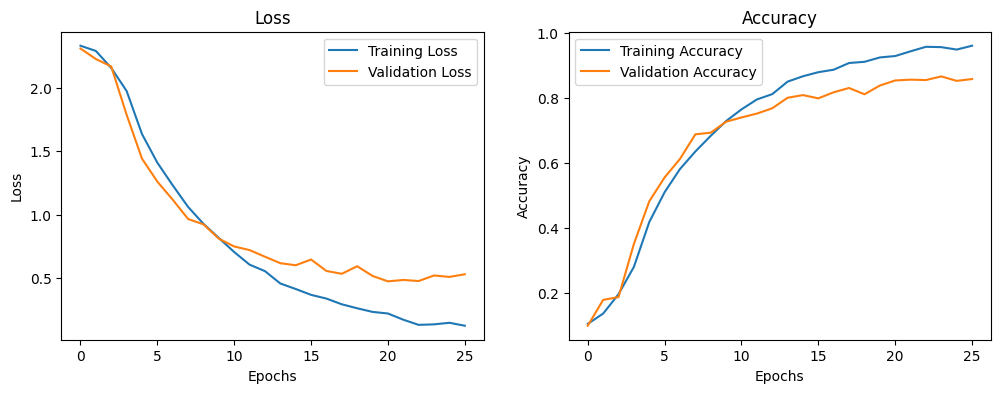

In [53]:
# Rebuild the best model using the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Define a function to rebuild the LSTM model with the best hyperparameters
def build_lstm_model(best_hyperparameters):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=best_hyperparameters.get('units_layer1'),
        activation=best_hyperparameters.get('activation_layer1'),
        input_shape=input_shape,
        return_sequences=True
    ))
    model.add(Dropout(best_hyperparameters.get('dropout_layer1')))

    # Second LSTM layer
    model.add(LSTM(
        units=best_hyperparameters.get('units_layer2'),
        activation=best_hyperparameters.get('activation_layer2')
    ))
    model.add(Dropout(best_hyperparameters.get('dropout_layer2')))

    # Output layer
    model.add(Dense(output_units, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model
model = build_lstm_model(best_hyperparameters)

# Train the model again, keeping track of the history for plotting
history = model.fit(
    X_train, y_train,
    epochs=100,  # Set the number of epochs here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [54]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8740000128746033


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 192)        │       148,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 416)            │     1,013,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         4,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,499,616 (13.35 MB)

 Trainable params: 1,166,538 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,333,078 (8.90 MB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.63      0.98      0.77       210
        car_horn       0.93      0.91      0.92       190
children_playing       0.77      0.62      0.68       201
        dog_bark       0.83      0.66      0.74       198
        drilling       0.91      0.85      0.88       205
   engine_idling       0.99      0.95      0.97       214
        gun_shot       0.86      0.94      0.90       172
      jackhammer       0.93      0.97      0.95       199
           siren       0.92      0.93      0.93       199
    street_music       0.82      0.67      0.74       212

        accuracy                           0.85      2000
       macro avg       0.86      0.85      0.85      2000
    weighted avg       0.86      0.85      0.85      2000



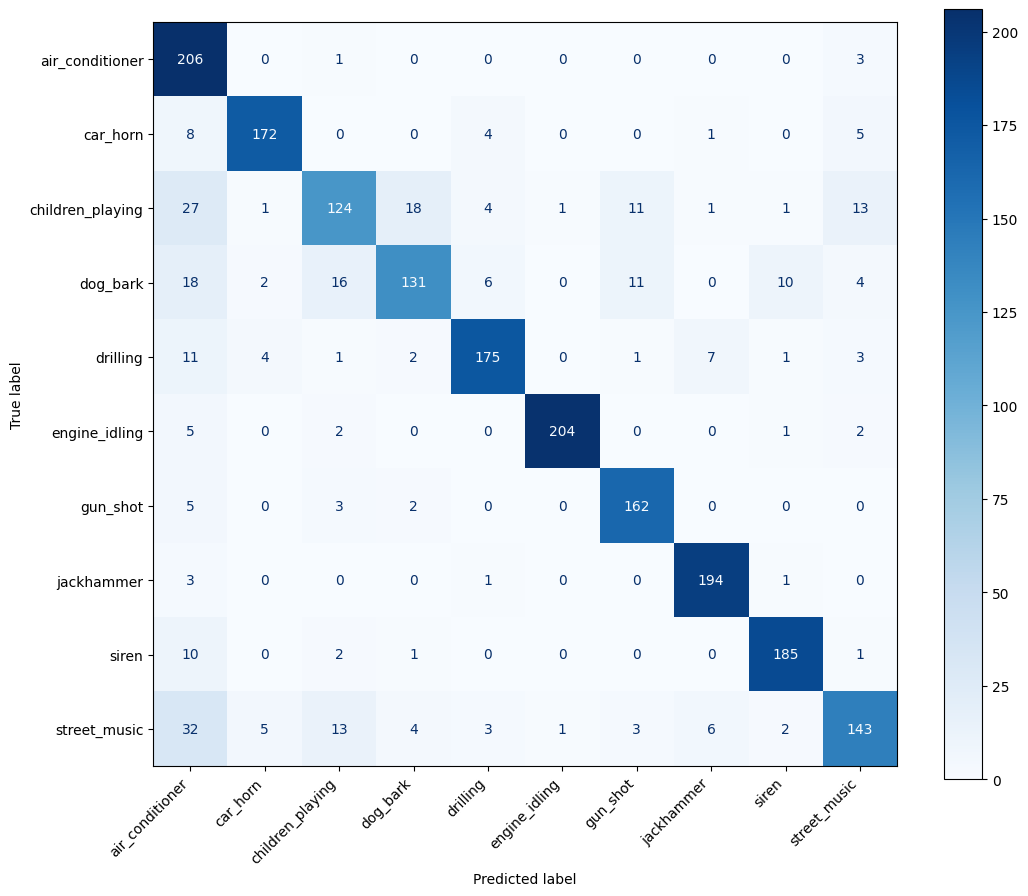

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Example of class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Get the class labels from the one-hot encoded predictions and true values
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Specify figure size directly in subplots

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the axis to the plot method

ax.set_xticklabels(disp.display_labels, rotation=45, ha='right')  # Rotate class names on x-axis for better readability

plt.show()